# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=50,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 50)
OOV context shape: (16562, 28)
Right context shape: (16562, 50)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=6.5632 | F1Score=0.2600
Batch-100: NLLLoss=5.8305 | F1Score=0.2844
Batch-150: NLLLoss=5.6856 | F1Score=0.3152
Batch-200: NLLLoss=4.4876 | F1Score=0.3372
Batch-250: NLLLoss=4.7733 | F1Score=0.3583
Batch-300: NLLLoss=4.1760 | F1Score=0.3760
Batch-350: NLLLoss=3.9035 | F1Score=0.3937
Batch-400: NLLLoss=4.5684 | F1Score=0.4103
Batch-450: NLLLoss=4.6977 | F1Score=0.4216
Batch-500: NLLLoss=4.6912 | F1Score=0.4336
Batch-518: NLLLoss=2.8926 | F1Score=0.4380

Mean NLLLoss: 4.5257 | Mean F1Score: 0.3513

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=3.4172 | F1Score=0.5719
Batch-100: NLLLoss=3.2717 | F1Score=0.5875
Batch-150: NLLLoss=2.3579 | F1Score=0.5975
Batch-200: NLLLoss=2.0955 | F1Score=0.6011
Batch-250: NLLLoss=2.8075 | F1Score=0.6056
Batch-300: NLLLoss=2.1715 | F1Score=0.6105
Batch-350: NLLLoss=2.3028 | F1Score=0.6154
Batch-400: NLLLoss=4.5892 | F1Score=0.6239
Batch-450: NLLLoss=2.2895 | F1Score=0.6277
Batch-500: NLLLoss=2.5085 | F1Score=0.6312
Batch-518: NLLLoss=1.1882 | F1Score=0.6329

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.7315 | Mean F1Score: 0.6063

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.1180 | F1Score=0.7306
Batch-100: NLLLoss=2.1126 | F1Score=0.7303
Batch-150: NLLLoss=3.2960 | F1Score=0.7285
Batch-200: NLLLoss=2.5372 | F1Score=0.7262
Batch-250: NLLLoss=1.8328 | F1Score=0.7254
Batch-300: NLLLoss=1.7280 | F1Score=0.7268
Batch-350: NLLLoss=1.3128 | F1Score=0.7308
Batch-400: NLLLoss=1.4087 | F1Score=0.7329
Batch-450: NLLLoss=1.4332 | F1Score=0.7357
Batch-500: NLLLoss=1.1911 | F1Score=0.7377
Batch-518: NLLLoss=2.3658 | F1Score=0.7387

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.8262 | Mean F1Score: 0.7301

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.1336 | F1Score=0.8106
Batch-100: NLLLoss=1.2077 | F1Score=0.8084
Batch-150: NLLLoss=2.0100 | F1Score=0.8048
Batch-200: NLLLoss=1.2233 | F1Score=0.8089
Batch-250: NLLLoss=1.1826 | F1Score=0.8081
Batch-300: NLLLoss=0.7627 | F1Score=0.8082
Batch-350: NLLLoss=1.8835 | F1Score=0.8096
Batch-400: NLLLoss=0.6471 | F1Score=0.8085
Batch-450: NLLLoss=0.5120 | F1Score=0.8106
Batch-500: NLLLoss=0.7302 | F1Score=0.8109
Batch-518: NLLLoss=1.4781 | F1Score=0.8111

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1917 | Mean F1Score: 0.8107

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.9266 | F1Score=0.8878
Batch-100: NLLLoss=0.4381 | F1Score=0.8820
Batch-150: NLLLoss=0.6383 | F1Score=0.8807
Batch-200: NLLLoss=0.7479 | F1Score=0.8782
Batch-250: NLLLoss=0.8338 | F1Score=0.8767
Batch-300: NLLLoss=0.6124 | F1Score=0.8728
Batch-350: NLLLoss=0.5509 | F1Score=0.8706
Batch-400: NLLLoss=0.6215 | F1Score=0.8707
Batch-450: NLLLoss=0.6165 | F1Score=0.8696
Batch-500: NLLLoss=0.7818 | F1Score=0.8705
Batch-518: NLLLoss=0.6325 | F1Score=0.8701

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.7180 | Mean F1Score: 0.8771

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.3735 | F1Score=0.9550
Batch-100: NLLLoss=0.2457 | F1Score=0.9488
Batch-150: NLLLoss=0.0966 | F1Score=0.9485
Batch-200: NLLLoss=0.0723 | F1Score=0.9458
Batch-250: NLLLoss=0.4512 | F1Score=0.9420
Batch-300: NLLLoss=0.2427 | F1Score=0.9406
Batch-350: NLLLoss=0.3492 | F1Score=0.9377
Batch-400: NLLLoss=0.2434 | F1Score=0.9361
Batch-450: NLLLoss=0.3429 | F1Score=0.9343
Batch-500: NLLLoss=0.1980 | F1Score=0.9325
Batch-518: NLLLoss=0.8256 | F1Score=0.9327

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3590 | Mean F1Score: 0.9428

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1629 | F1Score=0.9887
Batch-100: NLLLoss=0.1647 | F1Score=0.9872
Batch-150: NLLLoss=0.2828 | F1Score=0.9881
Batch-200: NLLLoss=0.0836 | F1Score=0.9883
Batch-250: NLLLoss=0.1434 | F1Score=0.9874
Batch-300: NLLLoss=0.2337 | F1Score=0.9874
Batch-350: NLLLoss=0.0362 | F1Score=0.9868
Batch-400: NLLLoss=0.2115 | F1Score=0.9863
Batch-450: NLLLoss=0.1510 | F1Score=0.9856
Batch-500: NLLLoss=0.3884 | F1Score=0.9847
Batch-518: NLLLoss=0.1167 | F1Score=0.9845

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1280 | Mean F1Score: 0.9873

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0336 | F1Score=0.9981
Batch-100: NLLLoss=0.0299 | F1Score=0.9978
Batch-150: NLLLoss=0.0193 | F1Score=0.9983
Batch-200: NLLLoss=0.0373 | F1Score=0.9981
Batch-250: NLLLoss=0.0095 | F1Score=0.9981
Batch-300: NLLLoss=0.0133 | F1Score=0.9980
Batch-350: NLLLoss=0.0693 | F1Score=0.9979
Batch-400: NLLLoss=0.0425 | F1Score=0.9976
Batch-450: NLLLoss=0.0510 | F1Score=0.9974
Batch-500: NLLLoss=0.0150 | F1Score=0.9975
Batch-518: NLLLoss=0.0761 | F1Score=0.9973

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0414 | Mean F1Score: 0.9980

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0090 | F1Score=0.9994
Batch-100: NLLLoss=0.0127 | F1Score=0.9994
Batch-150: NLLLoss=0.0109 | F1Score=0.9992
Batch-200: NLLLoss=0.0045 | F1Score=0.9994
Batch-250: NLLLoss=0.0092 | F1Score=0.9991
Batch-300: NLLLoss=0.0048 | F1Score=0.9992
Batch-350: NLLLoss=0.0088 | F1Score=0.9992
Batch-400: NLLLoss=0.0071 | F1Score=0.9989
Batch-450: NLLLoss=0.0072 | F1Score=0.9989
Batch-500: NLLLoss=0.0042 | F1Score=0.9989
Batch-518: NLLLoss=0.0064 | F1Score=0.9989

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0145 | Mean F1Score: 0.9992

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0073 | F1Score=0.9994
Batch-100: NLLLoss=0.0164 | F1Score=0.9989
Batch-150: NLLLoss=0.0055 | F1Score=0.9993
Batch-200: NLLLoss=0.0061 | F1Score=0.9993
Batch-250: NLLLoss=0.0072 | F1Score=0.9993
Batch-300: NLLLoss=0.0071 | F1Score=0.9992
Batch-350: NLLLoss=0.0058 | F1Score=0.9991
Batch-400: NLLLoss=0.0032 | F1Score=0.9992
Batch-450: NLLLoss=0.0055 | F1Score=0.9992
Batch-500: NLLLoss=0.0052 | F1Score=0.9992
Batch-518: NLLLoss=0.0051 | F1Score=0.9993

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0090 | Mean F1Score: 0.9993

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0030 | F1Score=1.0000
Batch-100: NLLLoss=0.0023 | F1Score=1.0000
Batch-150: NLLLoss=0.0012 | F1Score=0.9998
Batch-200: NLLLoss=0.0037 | F1Score=0.9997
Batch-250: NLLLoss=0.0041 | F1Score=0.9994
Batch-300: NLLLoss=0.0025 | F1Score=0.9994
Batch-350: NLLLoss=0.0026 | F1Score=0.9995
Batch-400: NLLLoss=0.1715 | F1Score=0.9995
Batch-450: NLLLoss=0.0067 | F1Score=0.9995
Batch-500: NLLLoss=0.0094 | F1Score=0.9994
Batch-518: NLLLoss=0.0695 | F1Score=0.9990

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0074 | Mean F1Score: 0.9996

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1741 | F1Score=0.9819
Batch-100: NLLLoss=0.4885 | F1Score=0.9553
Batch-150: NLLLoss=0.3469 | F1Score=0.9454
Batch-200: NLLLoss=0.1567 | F1Score=0.9450
Batch-250: NLLLoss=0.1743 | F1Score=0.9469
Batch-300: NLLLoss=0.1748 | F1Score=0.9486
Batch-350: NLLLoss=0.0802 | F1Score=0.9493
Batch-400: NLLLoss=0.0342 | F1Score=0.9514
Batch-450: NLLLoss=0.1111 | F1Score=0.9548
Batch-500: NLLLoss=0.0317 | F1Score=0.9571
Batch-518: NLLLoss=0.1816 | F1Score=0.9579

Huft 😥! Model not improved.
Mean NLLLoss: 0.1858 | Mean F1Score: 0.9551
Patience = 1/20❗

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0259 | F1Score=0.9981
Batch-100: NLLLoss=0.0076 | F1Score=0.9984
Batch-150: NLLLoss=0.0516 | F1Score=0.9977
Batch-200: NLLLoss=0.0047 | F1Score=0.9978
Batch-250: NLLLoss=0.0100 | F1Score=0.9980
Batch-300: NLLLoss=0.0054 | F1Score=0.9980
Batch-350: NLLLoss=0.0941 | F1Score=0.9980
Batch-400: NLLLoss=0.0729 | F1Score=0.9981
Batch-450: NLLLoss=0.0072 | F1Score=0.9983
Batch-500: NLLLoss=0.0150 | F1Score=0.9984
Batch-518: NLLLoss=0.0119 | F1Score=0.9984

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0169 | Mean F1Score: 0.9982

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0028 | F1Score=1.0000
Batch-100: NLLLoss=0.0034 | F1Score=0.9994
Batch-150: NLLLoss=0.0024 | F1Score=0.9996
Batch-200: NLLLoss=0.0023 | F1Score=0.9995
Batch-250: NLLLoss=0.0015 | F1Score=0.9996
Batch-300: NLLLoss=0.0013 | F1Score=0.9996
Batch-350: NLLLoss=0.0033 | F1Score=0.9996
Batch-400: NLLLoss=0.0021 | F1Score=0.9995
Batch-450: NLLLoss=0.0019 | F1Score=0.9995
Batch-500: NLLLoss=0.0011 | F1Score=0.9995
Batch-518: NLLLoss=0.0018 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0035 | Mean F1Score: 0.9996

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0012 | F1Score=0.9997
Batch-100: NLLLoss=0.0037 | F1Score=0.9998
Batch-150: NLLLoss=0.0022 | F1Score=0.9999
Batch-200: NLLLoss=0.0009 | F1Score=0.9999
Batch-250: NLLLoss=0.0013 | F1Score=0.9999
Batch-300: NLLLoss=0.0010 | F1Score=0.9999
Batch-350: NLLLoss=0.0009 | F1Score=0.9999
Batch-400: NLLLoss=0.0009 | F1Score=0.9999
Batch-450: NLLLoss=0.0016 | F1Score=0.9999
Batch-500: NLLLoss=0.0016 | F1Score=0.9998
Batch-518: NLLLoss=0.0017 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0022 | Mean F1Score: 0.9999

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0012 | F1Score=1.0000
Batch-100: NLLLoss=0.0010 | F1Score=1.0000
Batch-150: NLLLoss=0.0008 | F1Score=1.0000
Batch-200: NLLLoss=0.0016 | F1Score=1.0000
Batch-250: NLLLoss=0.0012 | F1Score=1.0000
Batch-300: NLLLoss=0.0015 | F1Score=1.0000
Batch-350: NLLLoss=0.0012 | F1Score=1.0000
Batch-400: NLLLoss=0.0008 | F1Score=1.0000
Batch-450: NLLLoss=0.0011 | F1Score=0.9999
Batch-500: NLLLoss=0.0010 | F1Score=0.9999
Batch-518: NLLLoss=0.0007 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0012 | Mean F1Score: 1.0000

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0019 | F1Score=0.9994
Batch-100: NLLLoss=0.0012 | F1Score=0.9992
Batch-150: NLLLoss=0.0008 | F1Score=0.9989
Batch-200: NLLLoss=0.0008 | F1Score=0.9990
Batch-250: NLLLoss=0.0020 | F1Score=0.9992
Batch-300: NLLLoss=0.0011 | F1Score=0.9993
Batch-350: NLLLoss=0.0006 | F1Score=0.9994
Batch-400: NLLLoss=0.0006 | F1Score=0.9995
Batch-450: NLLLoss=0.0011 | F1Score=0.9995
Batch-500: NLLLoss=0.0009 | F1Score=0.9996
Batch-518: NLLLoss=0.0012 | F1Score=0.9996

Huft 😥! Model not improved.
Mean NLLLoss: 0.0031 | Mean F1Score: 0.9993
Patience = 2/20❗

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0009 | F1Score=1.0000
Batch-100: NLLLoss=0.0006 | F1Score=1.0000
Batch-150: NLLLoss=0.0020 | F1Score=0.9998
Batch-200: NLLLoss=0.0011 | F1Score=0.9995
Batch-250: NLLLoss=0.0011 | F1Score=0.9995
Batch-300: NLLLoss=0.0020 | F1Score=0.9994
Batch-350: NLLLoss=0.0555 | F1Score=0.9989
Batch-400: NLLLoss=0.0164 | F1Score=0.9972
Batch-450: NLLLoss=0.0599 | F1Score=0.9914
Batch-500: NLLLoss=0.2917 | F1Score=0.9860
Batch-518: NLLLoss=0.3983 | F1Score=0.9847

Huft 😥! Model not improved.
Mean NLLLoss: 0.0624 | Mean F1Score: 0.9974
Patience = 3/20❗

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1618 | F1Score=0.9647
Batch-100: NLLLoss=0.0366 | F1Score=0.9664
Batch-150: NLLLoss=0.3069 | F1Score=0.9691
Batch-200: NLLLoss=0.0360 | F1Score=0.9710
Batch-250: NLLLoss=0.0435 | F1Score=0.9724
Batch-300: NLLLoss=0.1595 | F1Score=0.9736
Batch-350: NLLLoss=0.0570 | F1Score=0.9763
Batch-400: NLLLoss=0.0545 | F1Score=0.9774
Batch-450: NLLLoss=0.0137 | F1Score=0.9785
Batch-500: NLLLoss=0.2048 | F1Score=0.9793
Batch-518: NLLLoss=0.0500 | F1Score=0.9793

Huft 😥! Model not improved.
Mean NLLLoss: 0.0849 | Mean F1Score: 0.9725
Patience = 4/20❗

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0728 | F1Score=0.9969
Batch-100: NLLLoss=0.0052 | F1Score=0.9981
Batch-150: NLLLoss=0.0013 | F1Score=0.9979
Batch-200: NLLLoss=0.0028 | F1Score=0.9980
Batch-250: NLLLoss=0.0020 | F1Score=0.9984
Batch-300: NLLLoss=0.0119 | F1Score=0.9985
Batch-350: NLLLoss=0.0012 | F1Score=0.9986
Batch-400: NLLLoss=0.0008 | F1Score=0.9987
Batch-450: NLLLoss=0.0039 | F1Score=0.9988
Batch-500: NLLLoss=0.0011 | F1Score=0.9988
Batch-518: NLLLoss=0.0005 | F1Score=0.9988

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0078 | Mean F1Score: 0.9982

TRAINING SUMMARY
Best NLLLoss      : 0.0078
Best F1Score      : 0.9982
Training duration : 26.315 minutes.
Training date     : 2022-10-11 15:24:28.056143+08:00


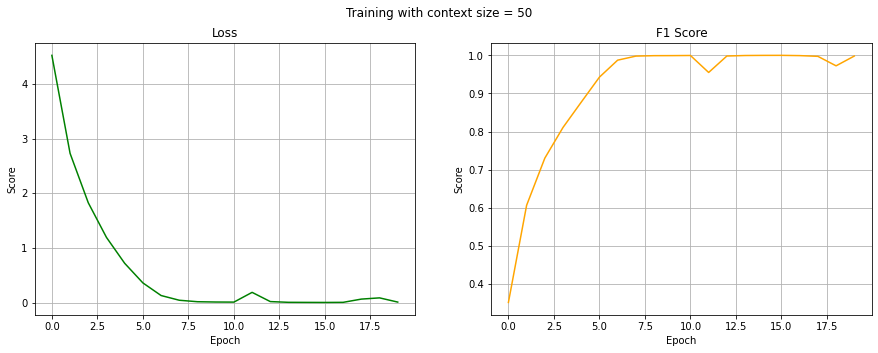

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[-3.601892  , -0.07298523, -2.244749  , ...,  7.298557  ,
         0.2855679 , -2.7030878 ],
       [ 0.97588235,  7.2211456 , -1.2655089 , ...,  2.7916858 ,
         2.588202  ,  1.4704989 ],
       [ 0.75321954,  5.6476417 , -2.2231045 , ..., -1.5505563 ,
        -1.3629488 , -2.7280757 ],
       ...,
       [-0.04665082, -4.3244243 ,  6.062445  , ...,  4.805164  ,
         1.6028614 ,  0.61766773],
       [ 0.16663542,  2.376115  ,  7.6425767 , ...,  1.1819327 ,
         7.832189  ,  1.0052701 ],
       [ 2.3024282 ,  3.7703881 , -4.207958  , ..., -1.5739542 ,
         5.229251  , -1.1864946 ]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[ 0.1342,  0.1299, -0.1404,  ...,  0.1896,  0.1654, -0.2612],
                      [ 0.0799, -0.0790, -0.2439,  ..., -0.3522,  0.0441,  0.2765],
                      [ 0.2742, -0.1410, -0.0873,  ..., -0.2782,  0.0991, -0.3104],
                      ...,
                      [ 0.2157, -0.3912, -0.0363,  ..., -0.1150,  0.2360, -0.5251],
                      [ 0.1368, -0.0360,  0.0492,  ...,  0.0396,  0.0623, -0.0514],
                      [ 0.0865, -0.2370,  0.0431,  ...,  0.1589,  0.1967, -0.0190]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[ 0.2283, -0.1450,  0.2155,  ...,  0.0404,  0.1337, -0.0233],
                      [ 0.1903,  0.1866, -0.0988,  ...,  0.0700,  0.0766, -0.0916],
                      [ 0.2148, -0.2673,  0.1639,  ...,  0.0982,  0.1791, -0.0135],
                      ...,
                      [ 0.1349, -0.0858,  0.2362,  ...,  0.1857,  0.062